## Experiment 1 OutLine

Aim: To evaluate emprically the convergence of a tied weight ResNet (which have a smooth Neural ODE interpolation) to a limit Neural ODE,
     with non-linear residual blocks (here, a conv net). Linear residual block convergence proven by Sander et al 2022.
1. Train Neural ODE with adaptive step size and very small tolerance (-> fine discretisation, approximately a limit Neural ODE)
2. Extract vector field parameters from trained Net
3. Evaluate the following which use the vector field (or as a residual block)
   - Tied weight ResNet with depth $N = 5,10,20,40$
   - Neural ODE with depth $N=5,10,20,40$ for both Euler and Huen solver
4. Measure discrepancy for each with the fine Neural ODE using the 2-Norm
5. Table created from discrepancies

In [22]:
# adapting code for Neural ODE from https://docs.kidger.site/diffrax/examples/neural_ode/

import time
import numpy as np
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import keras
from keras import layers



In [2]:
# Imports from our model .py file

from ModelsForMNIST import (
    Func,
    main_ODE,
    NeuralODE,
    NODEClassifier,
    ConvResNet,
    ConvTiedResNet,
)

Importing MNIST dataset

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 784).astype("float32") / 255.0


y_train = y_train.astype("int32")
y_test  = y_test.astype("int32")

Creating approximate limit Neural ODE

In [5]:
model_ref, losses = main_ODE(
    x_train=x_train,
    y_train=y_train,
    solver_choice=2, 
    tolerance=(1e-6, 1e-9),   # tight
    Func=Func,
    steps=1500,
    lr=1e-4,
    batch_size=64,             # Tsit5
    seed=0,
)

Step 0, Loss 2.3647689819335938
Step 100, Loss 1.8640689849853516
Step 200, Loss 1.0914084911346436
Step 300, Loss 0.6328824758529663
Step 400, Loss 0.4939711093902588
Step 500, Loss 0.28500688076019287
Step 600, Loss 0.22181764245033264
Step 700, Loss 0.3946564197540283
Step 800, Loss 0.3321007490158081
Step 900, Loss 0.3531215190887451
Step 1000, Loss 0.5256413221359253
Step 1100, Loss 0.4083608388900757
Step 1200, Loss 0.2321578562259674
Step 1300, Loss 0.36317676305770874
Step 1400, Loss 0.4581674635410309


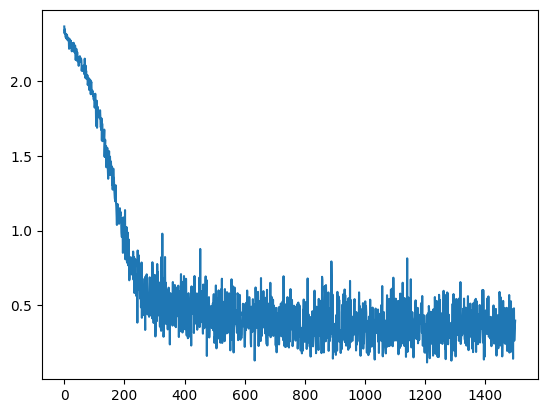

In [7]:
plt.plot(losses)

In [6]:
eqx.tree_serialise_leaves(
    "model_ref.eqx",
    model_ref
) # storing model parameters

In [48]:
# to recall parameters without repeating training:
key = jr.PRNGKey(0)

model_ref = NODEClassifier(
    Func=Func,
    solver_choice=2,
    tolerance=(1e-6, 1e-9),
    key=key,
)

model_ref = eqx.tree_deserialise_leaves(
    "model_ref.eqx",
    model_ref
)


In [49]:
def test_accuracy(model, x_test, y_test, batch_size=256):
    correct = 0
    total = 0
    for i in range(0, x_test.shape[0], batch_size):
        xb = x_test[i:i+batch_size]
        yb = y_test[i:i+batch_size]
        logits = jax.vmap(model)(xb)
        preds = jnp.argmax(logits, axis=1)
        correct += jnp.sum(preds == yb)
        total += yb.shape[0]
    return correct / total

print(f"Limit NODE test accuracy: {test_accuracy(model_ref, x_test, y_test)*100}%")


Limit NODE test accuracy: 90.44999694824219%


We see a approximate limit NODE test accuracy of 90.45% - lower than expected

Storing conv net parameters with reference flow

In [7]:
trained_func = model_ref.ode.func

def reference_flow(x):
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(trained_func),
        diffrax.Tsit5(),
        t0=0.0,
        t1=1.0,
        dt0=1e-3,
        y0 =x,
        stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-9),
        saveat=diffrax.SaveAt(t1=True),
    )
    return sol.ys[0]

Neural ODE solver as a function of solver choice and step size

In [47]:
def fixed_step_NODE(func, solver_choice, step_size, key):
    return NeuralODE(
        func=func,
        solver_choice=solver_choice,   # 0=Euler, 1=Heun, 2=Tsit5
        step_size=step_size,
        tolerance=False, key=key
    )

Error functions

In [9]:
def discretisation_error(ode, reference_flow, x):
    h_approx = jax.vmap(ode)(x)
    h_ref    = jax.vmap(reference_flow)(x)
    return jnp.mean(jnp.linalg.norm(h_approx - h_ref, axis=1))

Experiment

In [30]:
Ns = [5, 10, 20, 40,80,160,320]
errors_euler = []
errors_heun  = []
errors_resnet = []
euler_vs_net = []

x_probe = x_test[:200] # small fixed subset

for N in Ns:
    print(N)
    step_size = 1.0 / N

    ode_euler = fixed_step_NODE(trained_func, solver_choice=0, step_size=step_size, key=jr.PRNGKey(0))
    ode_heun  = fixed_step_NODE(trained_func, solver_choice=1, step_size=step_size, key=jr.PRNGKey(0))
    tied_resnet = ConvTiedResNet(trained_func, N, key=jr.PRNGKey(0))
    
    errors_euler.append(float(discretisation_error(ode_euler, reference_flow, x_probe)))
    errors_heun.append(float(discretisation_error(ode_heun,  reference_flow, x_probe)))
    errors_resnet.append(float(discretisation_error(tied_resnet, reference_flow, x_probe)))
    euler_vs_net.append(float(discretisation_error(tied_resnet, ode_euler, x_probe)))

5
10
20
40
80
160
320


In [31]:
print(euler_vs_net)

[7.490998541470617e-06, 9.393045729666483e-06, 1.0302740520273801e-05, 1.3252692951937206e-05, 1.946282463904936e-05, 2.5911476768669672e-05, 3.8582431443501264e-05]


In [32]:
print(errors_resnet)

[50.73331832885742, 32.2292366027832, 18.598739624023438, 10.067745208740234, 5.249488353729248, 2.6820387840270996, 1.355794906616211]


In [33]:
print(errors_euler)

[50.73331832885742, 32.2292366027832, 18.598739624023438, 10.067744255065918, 5.249488830566406, 2.6820385456085205, 1.3557958602905273]


In [34]:
print(errors_heun)

[10.168496131896973, 3.161543607711792, 0.8822410106658936, 0.2323809564113617, 0.05954785645008087, 0.01507288683205843, 0.003799878293648362]


In [41]:
h = [1/N for N in Ns]

log_h = np.log(h)
log_err_euler = np.log(errors_euler)
log_err_heun  = np.log(errors_heun)

p_euler, c_euler = np.polyfit(log_h, log_err_euler, 1)
p_heun,  c_heun  = np.polyfit(log_h, log_err_heun, 1)

print("Estimated convergence rates:")
print(f"Euler: p ≈ {p_euler}")
print(f"Heun:  p ≈ {p_heun}")

Estimated convergence rates:
Euler: p ≈ 0.8812877584467241
Heun:  p ≈ 1.9097038192594658


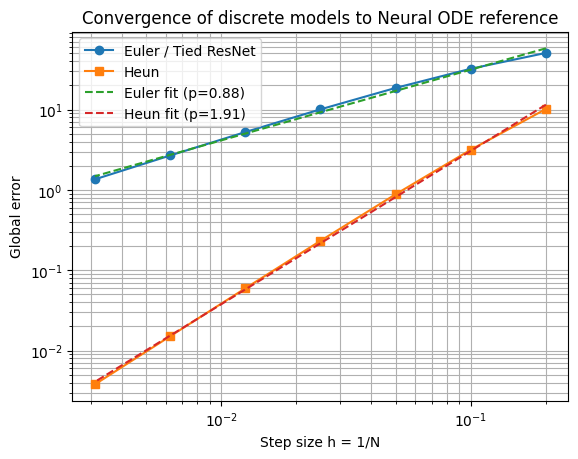

In [45]:
plt.loglog(h, errors_euler, 'o-', label="Euler / Tied ResNet")
plt.loglog(h, errors_heun,  's-', label="Heun")

# lines of best fit
plt.loglog(h, np.exp(c_euler) * h**p_euler, '--', label=f"Euler fit (p={p_euler:.2f})")
plt.loglog(h, np.exp(c_heun)  * h**p_heun,  '--', label=f"Heun fit (p={p_heun:.2f})")

plt.xlabel("Step size h = 1/N")
plt.ylabel("Global error")
plt.legend()
plt.grid(True, which="both")
plt.title("Convergence of discrete models to Neural ODE reference")
plt.savefig("convergence_plot.pdf", bbox_inches="tight")
plt.show()